In [1]:
#加入第一轮主动学习筛选出的配方结果，V4里的10号配方
#加入第0轮主动学习筛选出的配方结果，V4里的1210号配方

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner, CommitteeRegressor#modAL官方文档可查
from modAL.disagreement import max_std_sampling


# metrics
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
f = open("D:\sklearn学习\DCPD力学性能\玻璃化转变温度0802\玻璃化转变温度_主动学习第二轮.csv", encoding = 'utf-8')

In [3]:
df = pd.read_csv(f, header = None)
df

,0,1,2,3,4,5,6
0,174.477332,0,5,100,109.657843,1.0,152.09
1,174.477332,0,5,110,109.657843,1.0,151.31
2,174.477332,0,5,120,109.657843,1.0,153.46
3,174.477332,0,5,130,109.657843,1.0,145.10
4,174.477332,0,5,140,109.657843,1.0,142.94
5,174.477332,0,5,150,109.657843,1.0,148.81
6,174.477332,0,3,100,109.657843,0.2,150.24
7,174.477332,0,3,100,109.657843,0.5,156.45
8,174.477332,0,3,100,109.657843,1.0,154.07
9,174.477332,0,8,100,109.657843,0.2,144.63


In [4]:
dat = df.dropna(axis = 'index', how = 'all', subset = [6])
dat

,0,1,2,3,4,5,6
0,174.477332,0,5,100,109.657843,1.0,152.09
1,174.477332,0,5,110,109.657843,1.0,151.31
2,174.477332,0,5,120,109.657843,1.0,153.46
3,174.477332,0,5,130,109.657843,1.0,145.10
4,174.477332,0,5,140,109.657843,1.0,142.94
5,174.477332,0,5,150,109.657843,1.0,148.81
6,174.477332,0,3,100,109.657843,0.2,150.24
7,174.477332,0,3,100,109.657843,0.5,156.45
8,174.477332,0,3,100,109.657843,1.0,154.07
9,174.477332,0,8,100,109.657843,0.2,144.63


In [7]:
ft_cols = dat.drop(columns=[6]).columns.tolist()
target_col = 6

In [8]:
XX = dat[ft_cols].values#特征值
yy = dat[target_col].values#目标值
print(XX.shape, yy.shape)

(19, 6) (19,)


In [8]:
from sklearn.model_selection import GridSearchCV

# 创建高斯回归模型
regressorGPR = GaussianProcessRegressor(kernel=RBF() + WhiteKernel())

# 定义超参数的候选值
param_grid = {
    'kernel__k1__length_scale': [0.1, 1.0, 10.0],  # 高斯核函数的长度尺度
    'kernel__k1__length_scale_bounds': [(1e-2, 1e3), (1e-1, 1e1)],  # 高斯核函数长度尺度的边界
    'kernel__k2__noise_level': [1e-6, 1e-3, 1e-1],  # 白噪声核函数的噪声水平
    'kernel__k2__noise_level_bounds': [(1e-10, 1e+1), (1e-5, 1e-2)],  # 白噪声核函数噪声水平的边界
}

# 创建网格搜索对象
grid_search = GridSearchCV(regressorGPR, param_grid, cv=5, scoring='neg_mean_squared_error')

# 使用特征矩阵X和目标变量y进行网格搜索
grid_search.fit(XX, yy)

# 输出最佳超参数组合
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

# 输出最佳模型
best_regressor = grid_search.best_estimator_
print("Best Regressor: ", best_regressor)

Best Parameters:  {'kernel__k1__length_scale': 0.1, 'kernel__k1__length_scale_bounds': (0.01, 1000.0), 'kernel__k2__noise_level': 0.001, 'kernel__k2__noise_level_bounds': (1e-05, 0.01)}
Best Regressor:  GaussianProcessRegressor(kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=0.001))


In [9]:
def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std) 
    return query_idx, X[query_idx]

In [10]:
np.random.seed(8) 

n_initial = 7
initial_idx = np.random.choice(range(len(XX)), size=n_initial, replace=False)
X_training, y_training = XX[initial_idx], yy[initial_idx]

# The kernel should be properly constructed.
kernel = RBF(length_scale=0.1, length_scale_bounds=(0.01, 1000.0)) \
         + WhiteKernel(noise_level=0.001, noise_level_bounds=(1e-05, 0.01))#高斯回归的超参数

regressor = ActiveLearner(#主动学习
    estimator=GaussianProcessRegressor(kernel=kernel),#高斯回归
    query_strategy=GP_regression_std,#最大的标准差
    X_training=X_training.reshape(-1, 6), y_training=y_training.reshape(-1, 1)
)

In [11]:
y_pred, y_std = regressor.predict(X_training.reshape(-1, 6), return_std=True)
y_pred, y_std = y_pred.ravel(), y_std.ravel()#排成列
#r2_score_init = round(r2_score(y_training.reshape(-1, 1),y_pred))

r2_score_init = r2_score(y_training.reshape(-1, 1),y_pred)
r2_score_init = round(r2_score_init, 3)
#print('Init R2 score: {}'.format(r2_score_init))
print(r2_score_init)

0.198


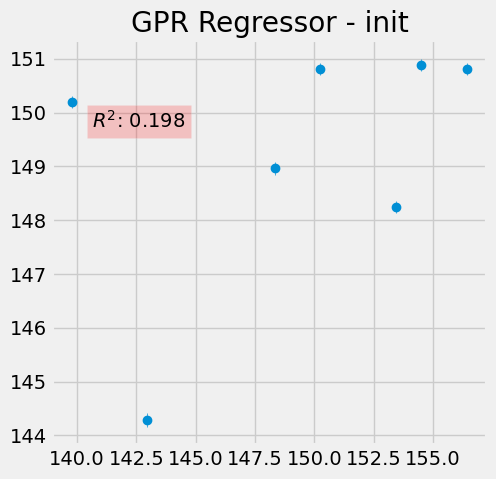

In [10]:
# visualizing the regressors
with plt.style.context('fivethirtyeight'):
    _,ax = plt.subplots(figsize=(5, 5))
    ax.errorbar(y_training.reshape(-1, 1), 
                y_pred,
               y_std,
               fmt='o', elinewidth=0.5)
    ax.text(0.2, 0.8, f"$R^2$: {r2_score_init}", 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax.transAxes, 
         bbox=dict(facecolor='red', alpha=0.2))
    plt.title('GPR Regressor - init')

In [12]:
query_idx_list = []

In [13]:
n_queries = 12
for idx in range(n_queries):
    query_idx, query_instance = regressor.query(XX)
    query_idx_list.append(query_idx)
    regressor.teach(XX[query_idx].reshape(-1, 6), yy[query_idx].reshape(1, -1))

In [14]:
XX_iter_1 = XX[np.concatenate((initial_idx, query_idx_list))]
print(f'Shape of New XX dataset:{XX_iter_1.shape}')
y_pred_iter1, y_std_iter1 = regressor.predict(XX_iter_1.reshape(-1, 6), return_std=True)
y_pred_iter1, y_std_iter1 = y_pred_iter1.ravel(), y_std_iter1.ravel()
r2_score_iter1 = r2_score(yy[np.concatenate((initial_idx, query_idx_list))].reshape(-1, 1), 
                          y_pred_iter1)
r2_score_iter1 = round(r2_score_iter1,2)
print('R2 score: {}'.format(r2_score_iter1))

Shape of New XX dataset:(19, 6)
R2 score: 0.34


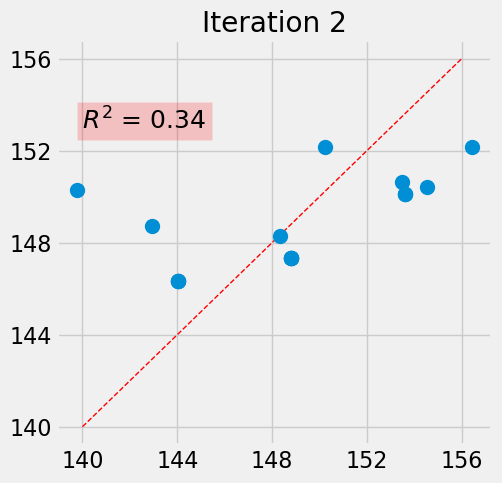

In [15]:
with plt.style.context('fivethirtyeight'):
    _, ax = plt.subplots(figsize=(5, 5))
    
    ax.plot([140,156], [140,156], 'r--', linewidth=1)
    
    ax.errorbar(yy[np.concatenate((initial_idx, query_idx_list))].reshape(-1, 1), 
                y_pred_iter1,
                y_std_iter1,
                fmt='o', 
                markersize=10,
                elinewidth=2, capsize = 4)
    ax.text(0.2, 0.8, f"$R^2$ = {r2_score_iter1}", 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax.transAxes, 
         bbox=dict(facecolor='red', alpha=0.2),
         fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.xticks(fontsize = 16)
    ax.set_xticks(range(140, 157, 4))
    ax.set_yticks(range(140, 157, 4))
    plt.title('Iteration 2')
    plt.savefig("iteration 2_0611.png",dpi=600,bbox_inches='tight')

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [14]:
def mean_absolute_error(true, pred):  
    abs_error = np.abs(true - pred)
    sum_abs_error = np.sum(abs_error)  
    mae_loss = sum_abs_error / true.size  
    return mae_loss

In [15]:
mean_absolute_error(yy, regressor.predict(XX))

3.0687266887946287

In [20]:
f8 = open("D:\sklearn学习\DCPD力学性能\玻璃化转变温度0717\玻璃化转变温度_GC2筛选用V4_特征值减少两轮版_主动学习筛选用.csv", encoding = 'utf-8')

In [21]:
df8 = pd.read_csv(f8, header = None)

In [22]:
X_pre = df8.values
X_pre.shape

(1331, 6)

In [23]:
GP_regression_std(regressor, X_pre)

(1320,
 array([174.4773318,   0.       ,  10.       , 150.       , 109.6578428,
          0.       ]))

In [24]:
zhudongjieguo_V4 = pd.DataFrame(regressor.predict(df8))

In [25]:
zhudongjieguo_V4.to_excel(excel_writer = r"D:\sklearn学习\DCPD力学性能\玻璃化转变温度0802_final_无Ipc\主动学习第二轮后V4配方预测结果_无Ipc.xlsx")

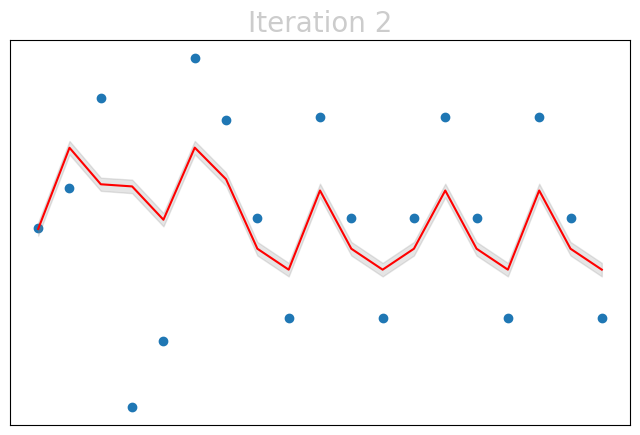

In [13]:
import matplotlib.pyplot as plt

# 定义横轴数据
x = range(len(XX_iter_1))

# 绘制预测概率区间图

fig = plt.figure(#facecolor='white', 
                 edgecolor=None, frameon=None,figsize=(8, 5))
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.yticks(fontsize = 18, color='black')
plt.xticks(fontsize = 18, color='black')

plt.scatter(x, yy[np.concatenate((initial_idx, query_idx_list))], label='Actual Tg')
plt.plot(x, y_pred_iter1, color='r', label='Predicted Tg')

# 计算并绘制预测概率区间
upper_bound = y_pred_iter1 + 3 * y_std_iter1
lower_bound = y_pred_iter1 - 3 * y_std_iter1
plt.fill_between(x, lower_bound, upper_bound, alpha=0.2, color='gray', label='Prediction Interval')

# 设置标题和标签
plt.title('Iteration 2', fontsize=20, color='black', alpha = 0.2)
#plt.xlabel('Data Point', fontsize=20, color='black')
#plt.ylabel('Target Value', fontsize=20, color='black')
plt.xticks([])  # 隐藏横坐标刻度标签
plt.yticks([])
# 添加图例

#plt.legend(prop={'size': 15}, loc = 'lower left')

# 显示图形
plt.savefig("第2轮误差图_无Ipc2.png",dpi=600,bbox_inches='tight',transparent=True)
plt.show()

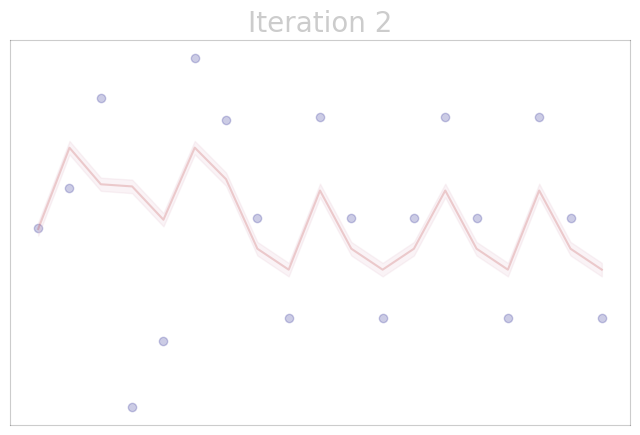

In [13]:
import matplotlib.pyplot as plt

# 定义横轴数据
x = range(len(XX_iter_1))

# 绘制预测概率区间图

fig = plt.figure(#facecolor='white', 
                 edgecolor=None, frameon=None,figsize=(8, 5))
plt.gca().spines['top'].set_color((0, 0, 0, 0.2))
plt.gca().spines['bottom'].set_color((0, 0, 0, 0.2))
plt.gca().spines['left'].set_color((0, 0, 0, 0.2))
plt.gca().spines['right'].set_color((0, 0, 0, 0.2))
plt.yticks(fontsize = 18, color='black')
plt.xticks(fontsize = 18, color='black')

plt.scatter(x, yy[np.concatenate((initial_idx, query_idx_list))], label='Actual Tg'
           , color=(0/255, 0/255, 128/255), alpha = 0.2)
plt.plot(x, y_pred_iter1, color=(178/255, 34/255, 34/255), label='Predicted Tg', alpha = 0.2)


# 计算并绘制预测概率区间
upper_bound = y_pred_iter1 + 3 * y_std_iter1
lower_bound = y_pred_iter1 - 3 * y_std_iter1
plt.fill_between(x, lower_bound, upper_bound, alpha=0.2, color=(230/255, 197/255, 210/255), label='Prediction Interval')


# 设置标题和标签
plt.title('Iteration 2', fontsize=20, color='black', alpha = 0.2)
#plt.xlabel('Data Point', fontsize=20, color='black')
#plt.ylabel('Target Value', fontsize=20, color='black')
plt.xticks([])  # 隐藏横坐标刻度标签
plt.yticks([])
# 添加图例

#plt.legend(prop={'size': 15}, loc = 'lower left')

# 显示图形
plt.savefig("0328第2轮误差图_无Ipc2_透明度0.2.png",dpi=600,bbox_inches='tight',transparent=True)
plt.show()